In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE # Example: Using SMOTE for oversampling
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from typing import List, Tuple, Dict, Any, Optional
import warnings
import sys

In [ ]:
dev_df_original = pd.read_csv('./dataset/KDDTrain+.txt')
test_df_original = pd.read_csv("./dataset/KDDTest+.txt")

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

dev_df_original.columns = columns
test_df_original.columns = columns

In [ ]:
assert dev_df_original.shape[1] == test_df_original.shape[1]

## Predefined Hyperparameters

In [ ]:
TARGET_COLUMN: str = 'attack'
RANDOM_STATE: int = 42
TEST_SET_SIZE: float = 0.2
LOW_VARIANCE_THRESHOLD: float = 0.01 #
VIF_THRESHOLD: float = 10.0

# Group Target Variables

In [ ]:
dev_df_original.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
dev_df_original.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
dev_df_original.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
dev_df_original.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

test_df_original.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
test_df_original.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
test_df_original.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
test_df_original.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

# Grouped Target Variable Distribution

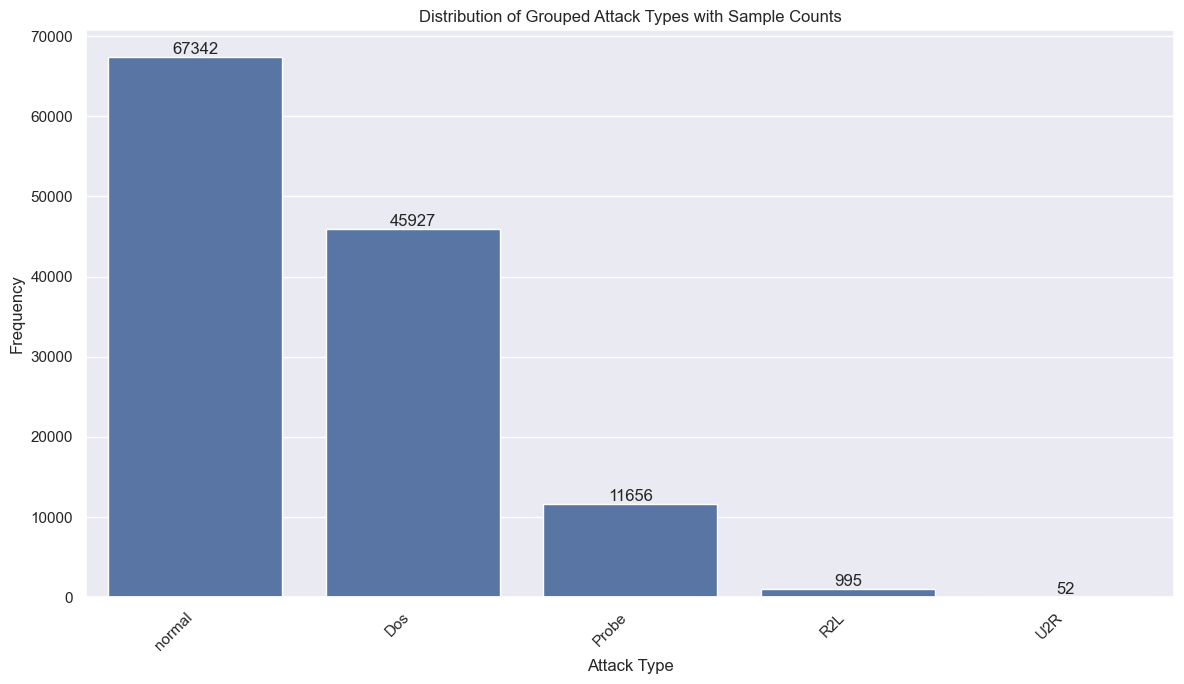

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(12, 7))
ax = sns.countplot(x='attack', data=dev_df_original, order = dev_df_original['attack'].value_counts().index)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Grouped Attack Types with Sample Counts')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Comment
Even if we had grouped the attack types, the target distribution is still imbalanced.

## Drop Variables with Low Variance: 'urgent', 'num_outbound_cmds'

In [ ]:
numerical_cols = dev_df_original.select_dtypes(include=np.number).columns.tolist() # Includes int, float

variances = dev_df_original[numerical_cols].var()

variance_threshold = 0.001

low_variance_cols = variances[variances < variance_threshold].index.tolist()

low_variance_df = dev_df_original[low_variance_cols]

print("Variances of Numerical Columns:")
print(variances)
print(f"\nColumns with variance < {variance_threshold}:")
print(low_variance_cols)

assert dev_df_original.shape[1] == test_df_original.shape[1]

Variances of Numerical Columns:
duration                       6.783553e+06
src_bytes                      3.446106e+13
dst_bytes                      1.617073e+13
land                           1.984190e-04
wrong_fragment                 6.427796e-02
urgent                         2.063844e-04
hot                            4.622401e+00
num_failed_logins              2.046596e-03
logged_in                      2.391315e-01
num_compromised                5.732259e+02
root_shell                     1.339779e-03
su_attempted                   2.038935e-03
num_root                       5.953461e+02
num_file_creations             2.341950e-01
num_shells                     4.920064e-04
num_access_files               9.874387e-03
num_outbound_cmds              0.000000e+00
is_host_login                  7.938272e-06
is_guest_login                 9.334015e-03
count                          1.311227e+04
srv_count                      5.276002e+03
serror_rate                    1.993236e-01


In [ ]:
drop_cols = ['land', 'urgent', 'num_shells', 'num_outbound_cmds', 'is_host_login']
dev_df = dev_df_original.drop(columns=drop_cols,inplace=False,axis=1)
test_df = test_df_original.drop(columns=drop_cols,inplace=False,axis=1)

print("Original dev data shape:",dev_df_original.shape, "--> Changed to:",dev_df.shape)
print("Original test data shape:", test_df_original.shape,"--> Changed to:",test_df.shape)
assert dev_df_original.shape[1] == test_df_original.shape[1]
assert dev_df.shape[1] == test_df.shape[1]

Original dev data shape: (125972, 43) --> Changed to: (125972, 38)
Original test data shape: (22543, 43) --> Changed to: (22543, 38)


# Double Check NaN

In [ ]:
dev_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
wrong_fragment                 0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_access_files               0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_s

In [ ]:
test_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
wrong_fragment                 0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_access_files               0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_s

# Check if duplicates exist

In [ ]:
dev_df.duplicated().sum()

9

# Columns identified from EDA

In [ ]:
CATEGORICAL_COLS: List[str] = ['protocol_type', 'service', 'flag']
SKEWED_COLS: List[str] = ['duration', 'src_bytes', 'dst_bytes', 'count','srv_count','dst_host_srv_count']

# Log Transform Skewed Features

In [ ]:
for col in SKEWED_COLS:
    new_col_name = 'log_'+col
    dev_df[new_col_name] = np.log1p(dev_df[col])
    test_df[new_col_name] = np.log1p(test_df[col])

assert dev_df.shape[1] == test_df.shape[1]

In [ ]:
dev_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,num_failed_logins,logged_in,...,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,log_duration,log_src_bytes,log_dst_bytes,log_count,log_srv_count,log_dst_host_srv_count
0,0,udp,other,SF,146,0,0,0,0,0,...,0.0,0.00,normal,15,0.0,4.990433,0.000000,2.639057,0.693147,0.693147
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.0,0.00,Dos,19,0.0,0.000000,0.000000,4.820282,1.945910,3.295837
2,0,tcp,http,SF,232,8153,0,0,0,1,...,0.0,0.01,normal,21,0.0,5.451038,9.006264,1.791759,1.791759,5.545177
3,0,tcp,http,SF,199,420,0,0,0,1,...,0.0,0.00,normal,21,0.0,5.298317,6.042633,3.433987,3.496508,5.545177
4,0,tcp,private,REJ,0,0,0,0,0,0,...,1.0,1.00,Dos,21,0.0,0.000000,0.000000,4.804021,2.995732,2.995732


In [ ]:
dev_df.drop(SKEWED_COLS,inplace=True,axis=1)
test_df.drop(SKEWED_COLS,inplace=True,axis=1)

assert dev_df.shape[1] == test_df.shape[1]

# Encode Categorical Vars

In [ ]:
dev_df[CATEGORICAL_COLS].nunique()

protocol_type     3
service          70
flag             11
dtype: int64

In [ ]:
dev_df['protocol_type'].unique()

array(['udp', 'tcp', 'icmp'], dtype=object)

In [ ]:
dev_df['service'].unique()

array(['other', 'private', 'http', 'remote_job', 'ftp_data', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

In [ ]:
dev_df['flag'].unique()

array(['SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3',
       'S2', 'OTH'], dtype=object)

## Comment
Categorical variables have no orders or meanings that could be represented in numbers, so we are going to just one-hot encode them.

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
encoder.fit(dev_df[CATEGORICAL_COLS])
encoded_dev_array = encoder.transform(dev_df[CATEGORICAL_COLS])
encoded_test_array = encoder.transform(test_df[CATEGORICAL_COLS])
new_feature_names = encoder.get_feature_names_out(CATEGORICAL_COLS)

In [ ]:
encoded_train_df = pd.DataFrame(encoded_dev_array, columns=new_feature_names, index=dev_df.index)
encoded_test_df = pd.DataFrame(encoded_test_array, columns=new_feature_names, index=test_df.index)

In [ ]:
dev_df_processed = dev_df.drop(columns=CATEGORICAL_COLS)
test_df_processed = test_df.drop(columns=CATEGORICAL_COLS)

In [ ]:
dev_df = pd.concat([dev_df_processed, encoded_train_df], axis=1)
test_df = pd.concat([test_df_processed, encoded_test_df],axis=1)

In [ ]:
print("Original dev data shape:",dev_df_original.shape, "--> Changed to:",dev_df.shape)
print("Original test data shape:", test_df_original.shape,"--> Changed to:",test_df.shape)

Original dev data shape: (125972, 43) --> Changed to: (125972, 116)
Original test data shape: (22543, 43) --> Changed to: (22543, 116)


## Comment
We do drop = 'first' to calculate VIF later.

# Handle Multicollinearity

## Comment
Since from EDA, we've seeen a lot of highly correlated variables, we calculate VIF so that we could only leave features that prevent us from multicollinearity problem.

In [ ]:
from tqdm.notebook import tqdm
def calculate_vif(df):
    print("Calculating VIF..")
    numeric_df = df.select_dtypes(include=np.number)
    X_const = add_constant(numeric_df, prepend=False, has_constant='skip')

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns
    vif_values = []
    for i in tqdm(range(X_const.shape[1]),desc = "exploring columns.."):
        feature_name = X_const.columns[i]

        if feature_name == 'const':
            vif_values.append(np.nan)
            continue
        try:
            vif = variance_inflation_factor(X_const.values, i)
            vif_values.append(vif)
        except Exception as e:
            vif_values.append(np.inf)

    vif_data["VIF"] = vif_values
    vif_data = vif_data.dropna(subset=['VIF']).reset_index(drop=True)
    return vif_data.sort_values(by='VIF', ascending=False)

In [ ]:
df_vif_check = dev_df.copy()
cols_to_check_vif = df_vif_check.select_dtypes(include=np.number).columns.tolist()
dropped_cols_vif = []
while True:
    current_numeric_df = df_vif_check[cols_to_check_vif]

    vif_data = calculate_vif(current_numeric_df)


    max_vif = vif_data['VIF'].iloc[0]
    max_vif_feature = vif_data['feature'].iloc[0]

    if max_vif == np.inf:
            df_vif_check.drop(columns=[max_vif_feature], inplace=True)
            cols_to_check_vif.remove(max_vif_feature)
            dropped_cols_vif.append(max_vif_feature)
            print("INF")
            continue #

    if max_vif > VIF_THRESHOLD:
        df_vif_check.drop(columns=[max_vif_feature], inplace=True)
        cols_to_check_vif.remove(max_vif_feature)
        dropped_cols_vif.append(max_vif_feature)
        print("ADDED")
        print(dropped_cols_vif)
        print()
    else:
        break # All remaining VIFs are below threshold

cols_to_keep = df_vif_check.columns.tolist()

Calculating VIF..


exploring columns..:   0%|          | 0/116 [00:00<?, ?it/s]

/opt/anaconda3/envs/el_ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


INF
Calculating VIF..


exploring columns..:   0%|          | 0/115 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root']

Calculating VIF..


exploring columns..:   0%|          | 0/114 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF']

Calculating VIF..


exploring columns..:   0%|          | 0/113 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http']

Calculating VIF..


exploring columns..:   0%|          | 0/112 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/111 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/110 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0']

Calculating VIF..


exploring columns..:   0%|          | 0/109 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/108 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/107 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate', 'dst_host_srv_serror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/106 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'protocol_type_tcp']

Calculating VIF..


exploring columns..:   0%|          | 0/105 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'protocol_type_tcp', 'dst_host_srv_rerror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/104 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'protocol_type_tcp', 'dst_host_srv_rerror_rate', 'same_srv_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/103 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'protocol_type_tcp', 'dst_host_srv_rerror_rate', 'same_srv_rate', 'dst_host_same_srv_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/102 [00:00<?, ?it/s]

ADDED
['service_ecr_i', 'num_root', 'flag_SF', 'service_http', 'srv_serror_rate', 'srv_rerror_rate', 'flag_S0', 'rerror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'protocol_type_tcp', 'dst_host_srv_rerror_rate', 'same_srv_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate']

Calculating VIF..


exploring columns..:   0%|          | 0/101 [00:00<?, ?it/s]

## Comment
From VIF calculation, we removed 15 variables.

In [ ]:
dev_df = dev_df[cols_to_keep]
test_df = test_df[cols_to_keep]

# Split Development set into Train & Validation Set

In [ ]:
X = dev_df.drop(columns=[TARGET_COLUMN])
y = dev_df[TARGET_COLUMN]
X_test, y_test = test_df.drop(columns=[TARGET_COLUMN]), test_df[TARGET_COLUMN]
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                        test_size=TEST_SET_SIZE,
                                                        random_state=RANDOM_STATE,
                                                        stratify=y)

# Scale numerical columns (Standardization)

In [ ]:
numerical_cols_for_scaling = [col for col in X.columns if len(X[col].unique()) > 2]
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols_for_scaling])
X_train_num_scaled = scaler.transform(X_train[numerical_cols_for_scaling])
X_val_num_scaled = scaler.transform(X_val[numerical_cols_for_scaling])
X_test_num_scaled = scaler.transform(X_test[numerical_cols_for_scaling])
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, index=X_train.index, columns=numerical_cols_for_scaling)
X_val_num_scaled_df = pd.DataFrame(X_val_num_scaled, index=X_val.index, columns=numerical_cols_for_scaling)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, index=X_test.index, columns=numerical_cols_for_scaling)

In [ ]:
X_train[numerical_cols_for_scaling] = X_train_num_scaled_df
X_val[numerical_cols_for_scaling] = X_val_num_scaled_df
X_test[numerical_cols_for_scaling] = X_test_num_scaled_df

In [ ]:
print("Shape of train df:",X_train.shape)
assert X_train.shape[0] == y_train.shape[0]
print("Shape of validation df:",X_val.shape)
assert X_val.shape[0] == y_val.shape[0]
print("Shape of test df:",X_test.shape)
assert X_test.shape[0] == y_test.shape[0]

Shape of train df: (100777, 100)
Shape of validation df: (25195, 100)
Shape of test df: (22543, 100)


Save dfs just in case

In [ ]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv",index=False)
X_val.to_csv("X_val.csv",index=False)
y_val.to_csv("y_val.csv",index=False)
X_test.to_csv("X_test.csv",index=False)
y_test.to_csv("y_test.csv",index=False)

# Use Random Oversampling because we have highly imbalanced target distribution

**We cannot use SMOTE because due to the highly imbalanced characteristic of the data, k_neighbors of SMOTE should be set to 1, in which is not recommended because it's less effective**

In [ ]:
sampler = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

In [ ]:
print("Distribution of train data before Random Oversampling:")
print(X_train.shape)
print("DISTRIBUTION OF TRAIN DATA AFTER RANDOM OVERSAMPLING")
print(X_resampled.shape)

Distribution of train data before Random Oversampling:
(100777, 100)
DISTRIBUTION OF TRAIN DATA AFTER RANDOM OVERSAMPLING
(269365, 100)


In [ ]:
assert X_resampled.shape[0] == y_resampled.shape[0]

In [ ]:
y_resampled.value_counts()

attack
Dos       53873
normal    53873
Probe     53873
R2L       53873
U2R       53873
Name: count, dtype: int64

## Comment
We could see that we have identical number of samples for the target variable in train dataset.

In [ ]:
X_resampled.to_csv("Oversampled_X_train.csv",index=False)
y_resampled.to_csv("Oversampled_y_train.csv",index=False)